# Evaluation homework

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv('course_lead_scoring.csv')

### Filling NAs

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.annual_income = df.annual_income.fillna(0)
df.employment_status = df.employment_status.fillna('NA')
df.location = df.location.fillna('NA')

### Splitting

In [62]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

X_train = df_train.drop('converted', axis=1)
y_train = df_train['converted'].values
X_val = df_val.drop('converted', axis=1)
y_val = df_val['converted'].values
X_test = df_test.drop('converted', axis=1)
y_test = df_test['converted'].values

df_train.shape, df_val.shape, df_test.shape

((876, 9), (293, 9), (293, 9))

### Question 1

In [63]:
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']
numerical_features = ['annual_income', 'interaction_count', 'lead_score', 'number_of_courses_viewed']

In [64]:
from sklearn.metrics import roc_auc_score

for col in numerical_features:
    print(col)
    print('////')
    print(roc_auc_score(y_train, X_train[col]))
    print('====')

annual_income
////
0.5519578313253012
====
interaction_count
////
0.738270176293409
====
lead_score
////
0.6144993577250176
====
number_of_courses_viewed
////
0.7635680590007088
====


number_of_courses_viewed

### Question 2

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [66]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [67]:
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred_val = model.predict_proba(X_val)[:, 1]

print(round(roc_auc_score(y_val, y_pred_val), 3))

0.817


### Question 3

In [41]:
scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [61]:
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,179,114,0,0,0.610922,1.0,0.758475
1,0.01,179,114,0,0,0.610922,1.0,0.758475
2,0.02,179,114,0,0,0.610922,1.0,0.758475
3,0.03,179,114,0,0,0.610922,1.0,0.758475
4,0.04,179,114,0,0,0.610922,1.0,0.758475


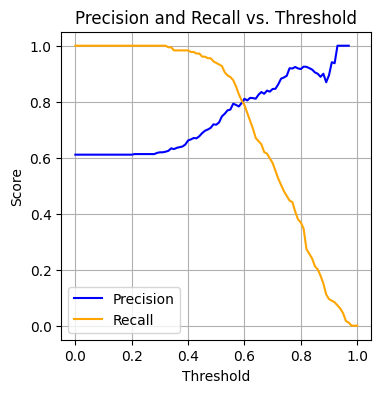

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision', color='blue')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Qeustion 4

In [52]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [60]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
56,0.56,157,41,22,73,0.792929,0.877095,0.832891


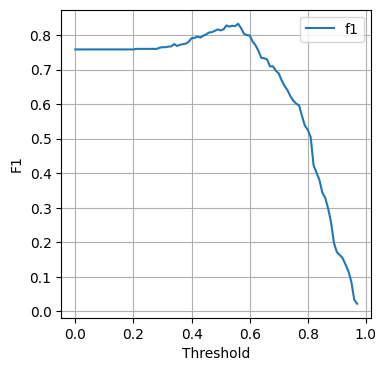

In [56]:
plt.figure(figsize=(4, 4))
plt.plot(df_scores['threshold'], df_scores['f1'], label='f1')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.legend()
plt.grid(True)
plt.show()

### Question 5

In [79]:
from sklearn.model_selection import KFold

n_splits = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

dv = DictVectorizer(sparse=False)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred_val = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred_val)
    scores.append(auc)

np.array(scores).std()

np.float64(0.03580711942905165)

### Question 6

In [83]:
C = [0.000001, 0.001, 1]

C_scores = []
scores = []

for c in C:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred_val = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred_val)
        scores.append(auc)

    C_scores.append((round(np.array(scores).mean(), 3), round(np.array(scores).std(), 3)))

C_scores

[(np.float64(0.56), np.float64(0.024)),
 (np.float64(0.867), np.float64(0.029)),
 (np.float64(0.822), np.float64(0.036))]